In [ ]:
pip install openseespy

## **Modeling this Turbine**
**65-kW Wind Turbine courtesy of UCSD**
<img src='Research\Turbine.PNG' width="300" height="300">

In [8]:
# following example on http://opensees.berkeley.edu/wiki/index.php/Elastic_Frame_Example
# running dynamic ground motion

%matplotlib notebook

# import OpenSees and libraries
from openseespy.opensees import *
from openseespy.postprocessing.Get_Rendering import *

# numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
from math import sqrt
import pandas as pd
import csv

# system commands
import os, os.path
import glob
import shutil

In [9]:
def buildmodel(angle):

    # -------------------------------
    #       Generate Model
    # -------------------------------

    # remove existing model
    wipe()
    wipeAnalysis()
    # remove existing results
    # explanation here: https://stackoverflow.com/a/31989328
    def remove_thing(path):
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.remove(path)

    def empty_directory(path):
        for i in glob.glob(os.path.join(path, '*')):
            remove_thing(i)

    empty_directory('modes')
    empty_directory('output')

    # ---------------------------------------
    #   Generate model and static analysis
    # ---------------------------------------

    # set modelbuilder
    model('basic', '-ndm', 3, '-ndf', 6)

    # units: in, kip, s
    # dimensions
    ft = 12.0
    inch = 1.0
    g = 386.1 #in/s^2
    kip = 1.0
    ksi = kip/(inch**2)
    s = 1

    # material properties
    Es = 29000*ksi
    Gs = 11500*ksi

    # -------------------------------
    #       Create Nodes
    # -------------------------------
    # command: node(nodeID, x-coord, y-coord, z-coord)
    # command: node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
    # Note: Ian Prowell Dissertation: Split into 30 beam-column elements

    # specify number of elements of each portion of the tower
    eldiv = 6

    # Defining the first node
    nodeTag = 1
    node(nodeTag, 0.0, 0.0, 0.0)

    # Heights of tower sections
    hbot = 238.2*inch
    hbottap = 74.8*inch
    hmid = 237.2*inch
    hmidtap = 74.8*inch
    htop = 263*inch # to reach the top of the nacelle 238 og 
    #angle = 5*math.pi/180
    
    # Lower tower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = (hbot/eldiv)*(j + 1)
        node(nodeTag, h*math.sin(angle), 0.0, h*math.cos(angle))

    # Tapered lower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + (hbottap/eldiv)*(j + 1)
        node(nodeTag, h*math.sin(angle), 0.0, h*math.cos(angle))

    # Middle tower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + hbottap + (hmid/eldiv)*(j + 1)
        node(nodeTag, h*math.sin(angle), 0.0, h*math.cos(angle))

    # Tapered middle section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + hbottap + hmid + (hmidtap/eldiv)*(j + 1)
        node(nodeTag, h*math.sin(angle), 0.0, h*math.cos(angle))

    # Top tower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + hbottap + hmid + hmidtap + (htop/eldiv)*(j + 1)
        node(nodeTag, h*math.sin(angle), 0.0, h*math.cos(angle))

    # restraints
    # command: fix(nodeID, DOF1, DOF2, DOF3, DOF4, DOF5, DOF6) 0 = free, 1 = fixed
    # Use a fixed connection for now
    fix(1, 1, 1, 1, 1, 1, 1)

    # geometric transformation for beam-columns
    # command: geomTransf('Type', TransfTag)
    # see https://opensees.berkeley.edu/wiki/index.php/Linear_Transformation 
    geomTransf('Corotational', 1, 0, -1, 0) #columns
    #Corotational
    # -------------------------------
    #       Define Elements
    # -------------------------------

    # initialize lists
    D = [] # diameters in
    A = [] # areas in^2
    I = [] # area moment of inertia in^4
    J = [] # polar moment of inertia in^4
    dM = [] # distributed masses kip*s^2/in
    V = [] # volumes in^3
    H = [] # height of each element in
    t = 0.21*inch # thickness is constant


    # Determining the diameters, areas, area moment of inertias, and polar moments of each discretized tower segment
    # diameters of tower
    dbot = 78.7*inch
    dmid = 62.9*inch
    dtop = 47.2*inch

    index = 0

    # Lower tower section (Split into eldiv elemenets)
    for j in range(eldiv):
        H.append(hbot/eldiv)
        D.append(dbot)
        A.append(((D[index])**2 - (D[index] - (2*t))**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Tapered lower section (Split into eldiv elements)
    for j in range(eldiv):
        H.append(hbottap/eldiv)
        d = ((j + 1)/(2*eldiv))*(dmid-dbot) + dbot # interpolating for the diameter based on eldiv
        D.append(d)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Middle tower section (Split into eldiv elements)
    for j in range(eldiv):
        H.append(hmid/eldiv)
        D.append(dmid)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Tapered middle section (Split into eldiv elements)
    for j in range(eldiv):
        H.append(hmidtap/eldiv)
        d = ((j + 1)/(2*eldiv))*(dtop-dmid) + dmid # interpolating for the diameter based on eldiv
        D.append(d)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Top tower section
    for j in range(eldiv):
        H.append(htop/eldiv)
        D.append(dtop)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Determining volumes of tower segments
    index = 0

    # Lower tower section (Split into eldiv elemenets)
    for j in range(eldiv):
        v = math.pi*(hbot/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
        V.append(v)
        index += 1

    # Tapered lower section (Split into eldiv elements)
    for j in range(eldiv):
        dlower = ((dmid-dbot)*j)/(eldiv) + dbot
        dhigher = ((dmid-dbot)*(j+1))/(eldiv) + dbot
        v = math.pi*(hbottap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 + (dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
        V.append(v)
        index += 1    

    # Middle tower section (Split into eldiv elements)
    for j in range(eldiv):
        v = math.pi*(hmid/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
        V.append(v)
        index += 1

    # Tapered middle section (Split into eldiv elements)
    for j in range(eldiv):
        dlower = ((dtop-dmid)*j)/(eldiv) + dmid
        dhigher = ((dtop-dmid)*(j+1))/(eldiv) + dmid
        v = math.pi*(hmidtap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 +(dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
        V.append(v)
        index += 1    

    # Top tower section (Split into eldiv elements)
    for j in range(eldiv):
        v = math.pi*(htop/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
        V.append(v)
        index += 1


    mtotal = 14.101*kip/g
    vtotal = sum(V)
    htotal = hbot + hbottap + hmid + hmidtap + htop
    
    # Determining distributed masses of tower segments
    # Entire tower section (Split into 5*eldiv elemenets)
    for j in range(len(H)):
        distm = (mtotal*V[j])/(vtotal*H[j]) # mass/height constant
        dM.append(distm)

    # Defining the elements and determining areas, area moment of inertias, and polar inertias for each section
    # Cylindrical sections => Ix = Iy 
    # Cylindrical sections => J = Iz = 2*Ix = (D^4-(D-t)^4)*(pi/32) 

    # Assigning element properties
    # create elastic beam-column elements - 
    # command: element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, G_mod, Jxx, Iy, Iz, transfTag, <'-mass', mass>, <'-cMass'>)
    # define the columns  
    for j in range(len(H)):
        element('elasticBeamColumn', j+1, j+1, j+2, A[j], Es, Gs, J[j], I[j], I[j], 1, '-mass', dM[j])

    # Uncomment to see how the turbine twists
    # node(nodeTag +1, 0.0, 10.0*ft, h)
    # geomTransf('Linear', 2, 0, 0, 1) #columns
    # element('elasticBeamColumn', len(H) + 1, len(H) + 1, len(H) + 2, A[len(H)-2], Es, Gs, J[len(H)-2], I[len(H)-2], I[len(H)-2], 2, '-mass', dM[len(H)-2])

    # assign additional masses
    # masses only act at nodes that have DoF
    # command: mass(nodeID, dx, dy, dz, r@x, r@y, r@z)
    # rotational inertia for a point mass: I = mr^2
    whub = 9.4*kip
    mhub = whub/g #kip*s^2/in
    ### to-do: the box is slightly higher than the last node of the tower, should we add another node? how would it be connected to the rest of the tower?
    hhub = 888*inch # height of hub
    # node(len(H) + 2, 0.0, 0.0, hhub) # CHANGE the top height it this is used
    # rigidLink('beam', len(H)+1, len(H)+2)
    mass(len(H) + 1, mhub, mhub, mhub, 0.0, 0.0, 0.0)
    
    # return necessary lists and values
    return H, dM, whub

In [ ]:
# units: in, kip, s
# dimensions
ft = 12.0
inch = 1.0
g = 386.1 #in/s^2
kip = 1.0
ksi = kip/(inch**2)
s = 1

# Define range of angle of the wind turbine
theta1 = 0 # Degrees
theta2 = 10 # Degrees
dtheta = 0.01 # Define discretization of forcing frequencies 
thetasteps = range(int((theta2-theta1)/dtheta))

Mb = []
theta = []

for x in thetasteps:
    H, dM, whub = buildmodel((theta1 + x*dtheta*math.pi)/180) # Build model to determine natural frequency

    # --------------------------------
    #       Perform eigen analysis
    # --------------------------------

    numEigen = 30
    lameigenValues = eigen(numEigen)

    wn = [i ** 0.5 for i in lameigenValues]
    fn = [i / (2*math.pi) for i in wn]

    # set the rayleigh damping factors for nodes & elements
    rayleigh(0.0, 0.0, 0.0, 2*0.005/wn[0])


    # -------------------------------
    #       Set up Static analysis
    # -------------------------------
    # create TimeSeries 
    timeSeries("Linear", 1)

    # create plain load pattern
    # command pattern('Plain', tag, timeSeriesTag)


    pattern('Plain', 1, 1)

    # define static loading due to a uniform wind distribution and gravity

    # eleLoad command only allows for loads to occur along it's local axes, so use a simple transformation
    for j in range(len(H)):
        # eleNodes(elementTag), retrieves node tags in an element
    #    ndI, ndJ = eleNodes(j+1)
        # nodeCoord(nodeTag), retrives coordinates of a node
    #     dXYZ = np.subtract(nodeCoord(ndJ), nodeCoord(ndI))
    #     L = np.linalg.norm(dXYZ) # L = H[j]
        FZ = -H[j]*(dM[j]*g) # Total gravity load per segment
        # x,y,z are local, X,Y,Z are global
        # Load for gravity is in the Z direction
        xaxis = eleResponse(j+1, 'xaxis')
        yaxis = eleResponse(j+1, 'yaxis')
        zaxis = eleResponse(j+1, 'zaxis')
        # Change index to 0, 1, or 2 if global load in X-, Y-, or Z- direction, respectively, or use dot product
        # Transform global loads into local loads
        Fx = FZ*xaxis[2]
        Fy = FZ*yaxis[2]
        Fz = FZ*zaxis[2]
        # Transform local loads applied at center of element to distributed loads along the local axes
        wx = Fx/H[j]
    #     print("wx", wx)
    #     print('correct', (-dM[j]*g))
        wy = Fy/H[j]
        wz = Fz/H[j]
        # eleLoad('-ele', j+1, '-type', '-beamUniform', wy, wz, wx) eleLoad takes the order of local distributed load as: (wy, wz, wx)
        eleLoad('-ele', j+1, '-type', '-beamUniform', wy, wz, wx)

    load(len(H) + 1, 0, 0, -whub, 0, 0, 0)

    # ------------------------------
    # Start of analysis generation
    # ------------------------------

    # create system of equation (SOE)
    system("BandSPD")
    # create DOF numberer
    numberer("RCM")
    # create constraint handler
    constraints('Transformation')
    # create integration scheme (steps of 1.0)
    integrator("LoadControl", 1.0)
    # create solution algorithm
    algorithm("Newton")
    # create analysis object
    analysis("Static")
    # perform the analysis
    analyze(1)

    reactions() # call before nodeReaction
    node1Rx = nodeReaction(2, 1)
    node1Ry = nodeReaction(1, 2)
    node1Rz = nodeReaction(1, 3)
    node1Mx = nodeReaction(1, 4)
    node1My = nodeReaction(1, 5)
    node1Mz = nodeReaction(1, 6)
    Mb.append(node1My)
    theta.append(x*dtheta)
    
    
#     print('Rx =', node1Rx)
#     print('Ry =', node1Ry)
#     print('Rz =', node1Rz)
#     print('Mx =', node1Mx)
#     print('My =', node1My)
#     print('Mz =', node1Mz)

# print("Overturning Moment (kip*in): ", Mb)
# print("Theta (Degrees): ", theta)

In [7]:
# units: in, kip, s
# dimensions
ft = 12.0
inch = 1.0
g = 386.1 #in/s^2
kip = 1.0
ksi = kip/(inch**2)
s = 1


# ----------------------------------
#       Define Sinusoidal Loading
# ----------------------------------

# Define parameters of the Sinusoidal Loading

T = 30 #Define how long the loading should go for
dt = 0.001 # Define the time step for input ground motion
tsteps = range(int((T/dt)))

t = [] # Define time list
for i in (tsteps):
    t.append(dt*i)

    
# Wave typical frequency and magnitude
# Define range of forcing frequency f (Hz)
f1 = 0.2/s
f2 = 0.3/s
df = 0.01 # Define discretization of forcing frequencies 
fsteps = range(int((f2-f1)/df))

# Wind typical frequency and magnitude
# # Define range of forcing frequency f (Hz)
# f1 = 0.05/s
# f2 = 2/s
# df = 0.1 # Define discretization of forcing frequencies 
# fsteps = range(int((f2-f1)/df))

# Blade typical frequency and magnitude
# # Define range of forcing frequency f (Hz)
# f1 = 0.5/s
# f2 = 2/s
# df = 0.1 # Define discretization of forcing frequencies 
# fsteps = range(int((f2-f1)/df))


# -------------------------------
#       Set up Dynamic analysis
# -------------------------------
f = []
peakVx = []
peakVy = []
peakMx = []
peakMy = []
dfVx = pd.DataFrame(index=[t]) # Define dataframe with all Base Shear x data
dfVy = pd.DataFrame(index=[t]) # Define dataframe with all Base Shear y data
dfMx = pd.DataFrame(index=[t]) # Define dataframe with all Overturning Moment about the x axis data
dfMy = pd.DataFrame(index=[t]) # Define dataframe with all Overturning Moment about the y axis data

# # Define a function to return the maximum value of the steady state response
# def eleMax(items, start = 0, end=None):
#     return abs(max(items[start:end], key=abs))

H, dM, whub = buildmodel(0*math.pi/180) # Build model to determine natural frequency
# --------------------------------
#       Perform eigen analysis
# --------------------------------

numEigen = 30
lameigenValues = eigen(numEigen)

wn = [i ** 0.5 for i in lameigenValues]
fn = [i / (2*math.pi) for i in wn]

print("Natural Frequencies:", fn, "Hz")

# compute the modal properties
#modalProperties("-print", "-file", "ModalReport.txt", "-unorm")

# -------------------------------------------
#       Plotting Structure and Modeshapes
# -------------------------------------------

# Display the active model with node and element tags
#plot_model("nodes","elements")

#plot_modeshape(1, 50)
#plot_modeshape(3, 50)
#plot_modeshape(6, 50)


# set the rayleigh damping factors for nodes & elements
rayleigh(0.0, 0.0, 0.0, 2*0.005/wn[0])

# Looping for each frequency
for i in fsteps:
    buildmodel(0*math.pi/180) # Wipe and build new model for every frequency
    
    # -------------------------------
    #       Set up Static analysis
    # -------------------------------

    # Call file that performs the static analysis
    %run OpenSeesRHAGravity.ipynb
    
    # Set the gravity loads to be constant & reset the time in the domain
    loadConst('-time', 0.0)

    # -------------------------------
    #       Set up Transient analysis
    # -------------------------------
    
    constraints('Plain')  			# how it handles boundary conditions
    numberer('RCM')
    system('BandGeneral')		    # how to store and solve the system of equations in the analysis
    algorithm('Newton')                 # use Newton-Raphson for linear analysis
    integrator('Newmark', 0.5, 0.25)        # create integration scheme, Newmark with alpha = 0.5, beta = 0.25
    analysis('Transient')      	    # define type of analysis static or transient

    # Create the convergence test, the norm of the residual with a tolerance of
    # 1e-12 and a max number of iterations of 10
    test('NormDispIncr', 1.0e-12,  10)

# # # Run each ground motion per each frequency wf and extract the maximum moment per each sinusoidal ground motion
    f.append(f1 + (df*i)) # Keeping track of the frequencies
    Vx = [] # Resetting each vector for each frequency
    Vy = []
    Mx = []
    My = []
    setTime(0) # Reset time
    time = []
    
    # Setting up variables for the transient analysis
    tCurrent = getTime()
    tFinal = T
    ok = 0
    # Getting the correct ground motion per frequency step
    timeSeries('Trig', i+2, 0, T, 1/f[i], '-factor', g*0.027787) 
    # patternTag, direction  accelTag
    pattern('UniformExcitation', i+2, 1, '-accel', i+2) # x direction

    # Perform the transient analysis
    while ok == 0 and tCurrent < tFinal:
        ok = analyze(1, dt)
        if ok != 0:
            print('WARNING' + str(tCurrent) + 'w' + str(i))
        # if the analysis fails try initial tangent iteration
            print("regular newton failed .. let's try an initial stiffness for this step")
            test('NormDispIncr', 1.0e-12,  100, 0)
            algorithm('ModifiedNewton', '-initial')
            ok = analyze(1, dt)
            if ok == 0:
                print("that worked .. back to regular newton")
            test('NormDispIncr', 1.0e-12,  10 )
            algorithm('Newton')
        # Store element forces per time step 
        tCurrent = getTime()
        time.append(tCurrent)     
        Vx.append(eleForce(1, 1)) # Vx
        Vy.append(eleForce(1, 2)) # Vy
        Mx.append(eleForce(1, 4)) # Mx
        My.append(eleForce(1, 5)) # My
    # Post-processing
    #maxVx = eleMax(Vx, int((T/dt)+1) - 20)
    #peakVx.append(maxVx)
    peakVx.append(abs(max(Vx, key=abs))) # kips
    peakVy.append(abs(max(Vy, key=abs))) # kips
    peakMx.append(abs(max(Mx, key=abs))) # kip inch
    peakMy.append(abs(max(My, key=abs))) # kip inch
    dfVx['w'+str(i)+"="+str(f[i])] = Vx
    dfVy['w'+str(i)+"="+str(f[i])] = Vy
    dfMx['w'+str(i)+"="+str(f[i])] = Mx
    dfMy['w'+str(i)+"="+str(f[i])] = My
    
dfVx.head(20)


Natural Frequencies: [1.7416607571994613, 1.7416607571994616, 12.93161742130589, 12.931617421305896, 31.418375759311676, 37.50532816107631, 37.505328161076356, 79.97732298601603, 79.97732298601618, 104.63755980264993, 133.17346388795116, 133.17346388795195, 196.81607870835435, 203.02975758995626, 203.02975758995635, 286.65036811997305, 286.6503681199735, 292.12693591179607, 381.99054626342075, 386.7368293026861, 386.736829302687, 472.34995652879036, 503.81938910837005, 503.81938910837175, 568.2869993159868, 623.5401856468239, 623.5401856468243, 648.9158433117016, 729.0586013039626, 766.585248992045] Hz
Note: you may need to restart the kernel to use updated packages.


WARNING can't set handler after analysis is created
WARNING can't set transient integrator in static analysis


Note: you may need to restart the kernel to use updated packages.


WARNING can't set handler after analysis is created
WARNING can't set transient integrator in static analysis


Note: you may need to restart the kernel to use updated packages.


WARNING can't set handler after analysis is created
WARNING can't set transient integrator in static analysis


Note: you may need to restart the kernel to use updated packages.


WARNING can't set handler after analysis is created
WARNING can't set transient integrator in static analysis


Note: you may need to restart the kernel to use updated packages.


WARNING can't set handler after analysis is created
WARNING can't set transient integrator in static analysis


Note: you may need to restart the kernel to use updated packages.


WARNING can't set handler after analysis is created
WARNING can't set transient integrator in static analysis


Note: you may need to restart the kernel to use updated packages.


WARNING can't set handler after analysis is created
WARNING can't set transient integrator in static analysis


Note: you may need to restart the kernel to use updated packages.


WARNING can't set handler after analysis is created
WARNING can't set transient integrator in static analysis


Note: you may need to restart the kernel to use updated packages.


WARNING can't set handler after analysis is created
WARNING can't set transient integrator in static analysis


,w0=0.2,w1=0.21000000000000002,w2=0.22,w3=0.23,w4=0.24000000000000002,w5=0.25,w6=0.26,w7=0.27,w8=0.28
0.000,0.000031,0.000033,0.000034,0.000036,0.000037,0.000039,0.000040,0.000042,0.000043
0.001,0.000099,0.000104,0.000109,0.000114,0.000119,0.000124,0.000129,0.000133,0.000138
0.002,0.000200,0.000210,0.000220,0.000230,0.000240,0.000250,0.000260,0.000270,0.000280
0.003,0.000325,0.000341,0.000358,0.000374,0.000390,0.000406,0.000423,0.000439,0.000455
0.004,0.000471,0.000494,0.000518,0.000541,0.000565,0.000588,0.000612,0.000635,0.000659
0.005,0.000633,0.000665,0.000696,0.000728,0.000760,0.000791,0.000823,0.000855,0.000886
0.006,0.000811,0.000851,0.000892,0.000932,0.000973,0.001013,0.001054,0.001094,0.001135
0.007,0.001002,0.001052,0.001102,0.001152,0.001202,0.001252,0.001302,0.001352,0.001402
0.008,0.001205,0.001266,0.001326,0.001386,0.001447,0.001507,0.001567,0.001627,0.001688
0.009,0.001421,0.001492,0.001563,0.001634,0.001706,0.001777,0.001848,0.001919,0.001990


In [10]:
print(f)
print(peakVx)
print(peakMy)
# print(f2)
# a = []
# b = []
# x = range(50)
# for i in x:
#     a.append(0)
#     b.append(0.49+(i*0.01))
# print(a)
# print(b)

[0.2, 0.21000000000000002, 0.22, 0.23, 0.24000000000000002, 0.25, 0.26, 0.27, 0.28]
[0.6926706750788894, 0.702097504378767, 0.7031410300834233, 0.7113669537980595, 0.7174527023953169, 0.7214157648381959, 0.7232763767481184, 0.7230581909007179, 0.720797791129789]
[420.77383273374363, 428.2295344565651, 430.7479469753885, 436.48752156084424, 440.8862322628416, 443.95546005321495, 445.7105115447804, 446.1675213842916, 445.3463883211116]


<IPython.core.display.Javascript object>


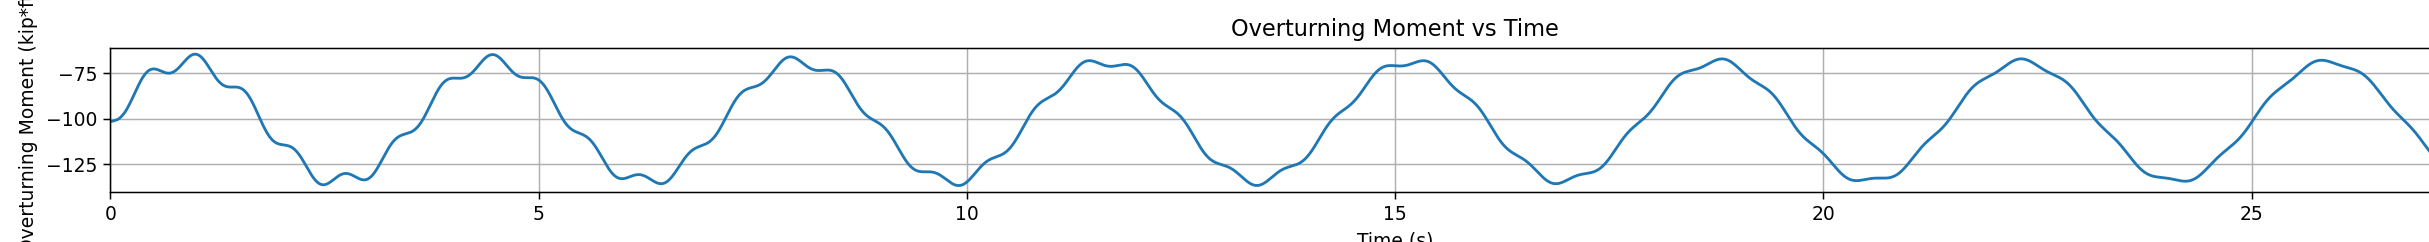

(0.0, 30.0)

In [6]:


#plt.plot(time, dfVx['w1'])
# dfMy.head(30)

#fig, ax = plt.subplots(dpi = 200, figsize=(20,3)) #time
fig, ax = plt.subplots(dpi = 150, figsize=(20,2)) #freq


# plt.plot(time, dfVx.iloc[:,50])
# plt.ylabel('Base Shear (kip)')
# plt.xlabel('Time (s)')
# plt.title('Base Shear vs Time')
# plt.grid(b=True)
# plt.show()

ax.plot(time, dfMy.iloc[:,8]/12)
ax.set_ylabel('Overturning Moment (kip*ft)')
ax.set_xlabel('Time (s)')
ax.set_title('Overturning Moment vs Time')
ax.grid(True)
plt.tight_layout()
plt.xlim([0,T])

# ax.plot(f, peakVx)
# ax.set_ylabel('Peak Base Shear (kip)')
# ax.set_xlabel('Forcing Frequency (Hz)')
# ax.set_title('Peak Base Shear vs Forcing Frequency')
# ax.grid(True)
# plt.tight_layout()
# plt.xlim([0,f2])


# plt.plot(f, peakVx)
# plt.ylabel('Peak Base Shear (kip)')
# plt.xlabel('Frequency (Hz)');


In [ ]:
# 3-D Plotting

#https://stackoverflow.com/questions/51765184/how-to-3d-plot-function-of-2-variables-in-python?noredirect=1&lq=1
#https://stackoverflow.com/questions/45396059/multiple-independent-lines-in-the-same-3d-axes
fig = plt.figure()
ax = fig.gca(projection='3d')

freq = pd.DataFrame(index=[t])

for i in range(20): # all frequencies: len(f)
    freq[i] =  [f[i]] * len(time)
    ax.plot(time,freq[i], dfVx.iloc[:,i])
    

# make labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Forcing Frequency (Hz)')
ax.set_zlabel('Base Shear (kip)')

plt.show()

In [ ]:
# 3-D Plotting Surface

#https://stackoverflow.com/questions/12423601/simplest-way-to-plot-3d-surface-given-3d-points
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import numpy
from numpy.random import randn
from scipy import array, newaxis

Vx3dall = []
Vx3d = []

for i in range(200): #len(f)
    for j in range(20000): #len(time)
        Vx3d = [time[j], f[i], dfVx.iat[j,i]]
        Vx3dall.append(Vx3d)

DATA = array(Vx3dall)
Xs = DATA[:,0]
Ys = DATA[:,1]
Zs = DATA[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

# make labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Forcing Frequency (Hz)')
ax.set_zlabel('Base Shear (kip)')

fig.tight_layout()

plt.show()
